In [1]:
import pandas as pd
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import random
import operator
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import softmax

Using TensorFlow backend.


In [2]:
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
file_name = 'r224n09.gzip'

node_name = file_name.strip('data_new/').strip('.gzip')

#general_variables
timestep = 20

#train on normal?
train_on_normal = False

In [4]:
data = pd.read_parquet(file_name)
data.reset_index(drop=True, inplace = True)
names = list(data)

In [5]:
data[data['New_label']>0].shape

(201, 463)

In [6]:
data = data[:int(data.shape[0]*1)]
test = data[int(data.shape[0]*0):]

#FIT scaler on train data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaler = scaler.fit(data.drop('timestamp', axis = 1).values)


if train_on_normal:
    data = data[data.New_label == 0]
    #normalized = scaler.transform(data.drop('timestamp', axis = 1).values)
    print(data.shape)
else:
    #normalized = scaler.transform(data.drop('timestamp', axis = 1).values)
    print(data.shape)

(13277, 463)


In [7]:
diffs = dict(data['timestamp'].diff().apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64'))
large_diffs = {i:diffs[i] for i in diffs.keys() if diffs[i] > 15}


diffs_test = dict(test['timestamp'].diff().apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64'))
large_diffs_test = {i:diffs_test[i] for i in diffs_test.keys() if diffs_test[i] > 15}


lk = list(large_diffs.keys())
lk.sort()
lk_test = list(large_diffs_test.keys())
lk_test.sort()

l_mod = [0] + lk + [data.shape[0] +1]
l_mod_test = [0] + lk_test + [test.shape[0] +1]

list_of_dfs = [data.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)]
list_of_dfs = [i for i in list_of_dfs if i.shape[0] > timestep]

list_of_dfs_test = [test.iloc[l_mod_test[n]:l_mod_test[n+1]] for n in range(len(l_mod_test)-1)]
list_of_dfs_test = [i for i in list_of_dfs_test if i.shape[0] > timestep]


lenghts = {i:list_of_dfs[i].shape[0] for i in range(len(list_of_dfs))}
lenghts_test = {i:list_of_dfs_test[i].shape[0] for i in range(len(list_of_dfs_test))}

n_train = sum([i.shape[0] for i in list_of_dfs])
n_test = sum([i.shape[0] for i in list_of_dfs_test])
print(n_train, n_test)

11568 11568


In [8]:
data_gens = []
for df in list_of_dfs:
    normalized = scaler.transform(df.drop('timestamp', axis = 1).values)
    data_gens.append(TimeseriesGenerator(normalized, normalized,
                               length=timestep, sampling_rate=1,
                               batch_size=1000))


data_gens_test = []
for df in list_of_dfs_test:
    normalized = scaler.transform(df.drop('timestamp', axis = 1).values)
    data_gens_test.append(TimeseriesGenerator(normalized, normalized,
                               length=timestep, sampling_rate=1,
                               batch_size=1000))    

In [9]:
train = np.vstack([np.array(i[0][0][:]) for i in data_gens])
test = np.vstack([np.array(i[0][0][:]) for i in data_gens_test])
print(train.shape)
print(test.shape)

(8148, 20, 462)
(8148, 20, 462)


In [10]:
y_train = train[:, -1, :]
y_test = test[:, -1, :]

In [11]:
def autoencoder_model(X):
    inputs = Input(shape=(timestep, X.shape[2]))
    L1 = LSTM(16, activation = 'selu', return_sequences = True)(inputs)
   #L2 = LSTM(16, activation = 'selu', return_sequences = True)(L1)
    L3 = LSTM(8, activation = 'selu', return_sequences = False)(L1)
    L4 = Dense(16, activation = 'selu')(L3)
    #L5 = Dense(, activation = 'selu')(L4)
    output = Dense(X.shape[2])(L4)
    model = Model(inputs = inputs, outputs = output)
    return model

In [12]:
model = autoencoder_model(train)
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.MeanSquaredError())
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 462)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 16)            30656     
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 462)               7854      
Total params: 39,454
Trainable params: 39,454
Non-trainable params: 0
_________________________________________________________________


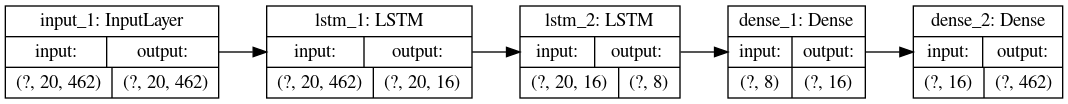

In [13]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir = 'LR')

In [14]:
model.fit(train, y_train,batch_size = 128, epochs = 3)

Epoch 1/3
8148/8148 [==============================] - 5s 591us/step - loss: 0.0416
Epoch 2/3
8148/8148 [==============================] - 4s 479us/step - loss: 0.0145
Epoch 3/3
8148/8148 [==============================] - 4s 474us/step - loss: 0.0126


In [15]:
predictions = model.predict(test)

predictions_df = pd.DataFrame(predictions, columns=names[1:])
val_df = pd.DataFrame(y_test, columns=names[1:])

normal_diff = val_df - predictions_df
normal_diff.head(5)

normal_diff['Total absolute reproduction error'] = normal_diff.abs().sum(axis=1)


normal_diff['real_label'] = val_df['New_label'].values

normal_diff['simple_label'] = normal_diff['real_label'].apply(lambda x: 1 if x > 0 else 0)

normal_diff['Softmax'] = normal_diff['Total absolute reproduction error'].apply(lambda x: x/max(normal_diff['Total absolute reproduction error']))


In [16]:
from sklearn.metrics import plot_det_curve
from sklearn.metrics import plot_roc_curve

In [17]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# calculate scores
auc = roc_auc_score(normal_diff['simple_label'], normal_diff['Softmax'])

print(auc)


0.7080395256448968


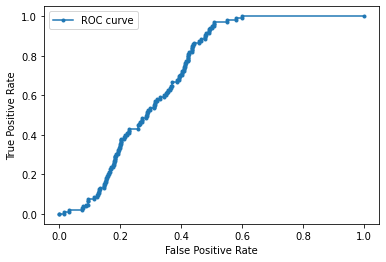

In [18]:
lr_fpr, lr_tpr, _ = roc_curve(normal_diff['simple_label'], normal_diff['Softmax'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ROC curve')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()